# Phabricator code review statistics

Trends and statistics for Firefox code reviews using the Phabricator code review system.

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns

sns.set_style("dark")

Our dataset is the list of transactions that took place on each phabricator revision of the Firefox repository. 

In [2]:
datafile = Path.cwd() / ".." / "data" / "processed" / "transactions.parq"
df = pd.read_parquet(str(datafile))

Make our columns a bit easier to understand.

In [3]:
df = df.rename(columns={"objectPHID": "revision"})

Extract the list of revision IDs.

In [4]:
revisions = pd.DataFrame({"revision": df["revision"].unique()})
revisions.count()

revision    16924
dtype: int64

Extract the transactions that open and close revisions.

In [5]:
opens = df[df["type"] == "create"][["revision", "dateCreated"]]
print("Revisions opened over this time period:", len(opens))

closes = df[df["type"] == "close"][["revision", "dateCreated"]]
print("Revisions closed over this time period:", len(closes))

Revisions opened over this time period: 16772
Revisions closed over this time period: 15243


Combine the transactions into single rows per revision.

In [6]:
revisions = pd.merge(revisions, opens, on="revision")

# Change the column name so it makes sense in the merged dataframe
closes = closes.rename(columns={"dateCreated": "dateClosed"})
revisions = pd.merge(revisions, closes, on="revision")

Find the duration from revision creation to revision close.

In [7]:
durations = revisions["dateClosed"] - revisions["dateCreated"]

In [8]:
durations.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

count                      15043
mean      6 days 12:20:30.225819
std      12 days 16:36:48.647852
min              0 days 00:01:16
25%              0 days 16:12:50
50%              2 days 01:38:09
75%              6 days 13:04:10
95%      28 days 23:20:56.100000
max            246 days 09:23:56
dtype: object

Limit the data to code reviews under 30 days to eliminate most outliers.

In [9]:
under30 = durations[durations.dt.days < 30]

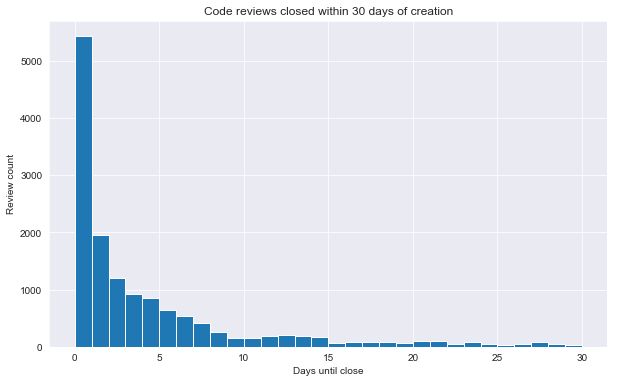

In [10]:
days_to_review = under30.dt.total_seconds() / (3600 * 24)

ax = days_to_review.hist(bins=30, figsize=(10,6))
ax.set(
    title="Code reviews closed within 30 days of creation",
    xlabel="Days until close",
    ylabel="Review count",
);

Zooming in again, let's look at the distribution of review closings within 72 hours of the review being posted.

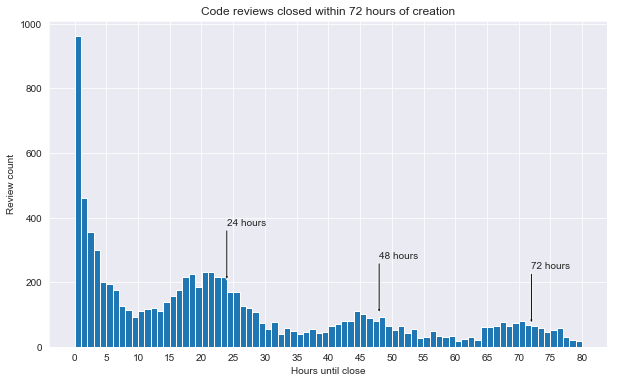

In [11]:
hours_to_review = under30.dt.total_seconds() / 3600
sample = hours_to_review[hours_to_review < 80]

ax = sample.hist(bins=80, figsize=(10,6))
ax.set(
    title="Code reviews closed within 72 hours of creation",
    xlabel="Hours until close",
    xticks=range(0,81,5),
    ylabel="Review count",
);

barsize = sample.round().value_counts()

for mark in (24, 48, 72):
    ax.annotate(f"{mark} hours", xy=(mark, barsize[mark] + 10),
                xytext=(mark, barsize[mark] + 200),
                arrowprops=dict(facecolor='black', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top')

The cyclic effect we are seeing could be because of weekends.  Our data includes all values that take 3 calendar days, not 3 *business* days.  Let's correct for this.

In [12]:
offset = revisions["dateCreated"] + pd.offsets.BusinessDay(3)
within3 = revisions[(revisions["dateClosed"] < offset)].copy()
len(within3)

9881

How many of our reviews cross over a weekend?

In [13]:
pct = len(within3) / len(within3[within3["dateClosed"].dt.weekday < within3["dateCreated"].dt.weekday])
print("%0.f%%" % pct)

5%


Redo the calculation using business days instead of calendar days.

In [14]:
from businessdays import bday_duration

within3["duration"] = within3.apply(
    lambda x: bday_duration(x["dateCreated"], x["dateClosed"]),
    axis="columns"
)

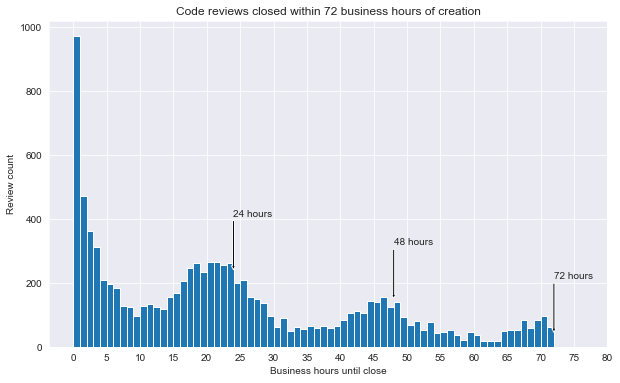

In [15]:
hours_to_review = within3["duration"].dt.total_seconds() / 3600
sample = hours_to_review[hours_to_review < 72]

ax = sample.hist(bins=72, figsize=(10,6))
ax.set(
    title="Code reviews closed within 72 business hours of creation",
    xlabel="Business hours until close",
    xticks=range(0,81,5),
    ylabel="Review count",
);

barsize = sample.round().value_counts()

for mark in (24, 48, 72):
    ax.annotate(f"{mark} hours", xy=(mark, barsize[mark] + 10),
                xytext=(mark, barsize[mark] + 200),
                arrowprops=dict(facecolor='black', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top')